In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 6)

df = pd.read_csv("/content/student-mat.csv")
print("Размер датасета:", df.shape)
df.head()

Размер датасета: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


## 1. Предобработка данных

In [4]:
# Сохраняем копию исходных данных перед обработкой
df_not_processed = df.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

### 1.1. Дубликаты и пропуски

In [5]:
print("Число дубликатов:", df.duplicated().sum())
print("\nКоличество пропусков по столбцам:")
df.isnull().sum()

Число дубликатов: 0

Количество пропусков по столбцам:


,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


В датасете нет дубликатов и пропусков, поэтому дополнительная обработка пропусков не требуется.

### 1.2. Обработка категориальных признаков

In [6]:
# Выделяем категориальные и числовые признаки
categorical_features = list(df.select_dtypes(include=['object']).columns)
numeric_features = list(df.select_dtypes(include=['int64', 'float64']).columns)

print("Категориальные признаки:", categorical_features)
print("Числовые признаки:", numeric_features)

Категориальные признаки: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Числовые признаки: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


In [7]:
# Разделим категориальные признаки на бинарные и с несколькими категориями
binary_cols = [col for col in categorical_features if df[col].nunique() == 2]
multi_cols = [col for col in categorical_features if df[col].nunique() > 2]

print("Бинарные категориальные:", binary_cols)
print("Многоклассовые категориальные:", multi_cols)

Бинарные категориальные: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Многоклассовые категориальные: ['Mjob', 'Fjob', 'reason', 'guardian']


In [8]:
# LabelEncoder для бинарных категориальных признаков
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

df[binary_cols].head()

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,0,0,1,0,0,1,0,0,0,1,1,0,0
1,0,0,1,0,1,0,1,0,0,0,1,1,0
2,0,0,1,1,1,1,0,1,0,1,1,1,0
3,0,0,1,0,1,0,1,1,1,1,1,1,1
4,0,0,1,0,1,0,1,1,0,1,1,0,0


In [9]:
# OneHotEncoder для многозначных категориальных признаков
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[multi_cols])

X_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(multi_cols))

# Удаляем исходные мультикатегориальные признаки и добавляем one-hot колонки
df_processed = df.drop(multi_cols, axis=1)
df_processed = pd.concat([df_processed.reset_index(drop=True),
                          X_encoded.reset_index(drop=True)], axis=1)

df_processed.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,18,1,0,0,4,4,2,2,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,17,1,0,1,1,1,1,2,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,0,15,1,1,1,1,1,1,2,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,0,15,1,0,1,4,2,1,3,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,0,16,1,0,1,3,3,1,2,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


После кодирования категориальных признаков получаем полностью числовой датафрейм `df_processed`, который можем использовать для масштабирования и кластеризации.

### 1.3. Масштабирование числовых признаков

In [10]:
# Для кластеризации будем использовать ВСЕ числовые признаки из исходного датасета,
# включая оценки и другие числовые характеристики.

numeric_for_clustering = list(df.select_dtypes(include=['int64', 'float64']).columns)
print("Числовые признаки для кластеризации:", numeric_for_clustering)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_for_clustering])

X_scaled[:5]

Числовые признаки для кластеризации: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


array([[-0.3630498 , -0.94817639,  1.02304645,  0.53539233, -0.63694109,
        -2.9383918 ,  1.14385567,  1.36037064,  0.79225076, -0.04228585,
        -0.44994364,  2.59713266, -1.25765629, -0.91967081, -1.01788137,
         0.50789938,  0.23094011, -2.23267743, -0.70844982,  0.06219406,
        -0.2360102 ,  0.8014793 , -0.54069866, -1.00378921, -0.39928949,
         0.03642446, -1.78246688, -1.25479105, -0.96493392],
       [-0.3630498 , -0.94817639,  0.23837976,  0.53539233, -0.63694109,
         0.34032221, -1.60000865, -1.39997047, -0.64324947, -0.04228585,
        -0.44994364, -0.38504002,  0.7951298 , -0.91967081, -1.01788137,
        -1.96889391,  0.23094011,  0.44789274, -0.70844982,  1.17886012,
        -0.2360102 , -0.09790798, -0.54069866, -1.00378921, -0.39928949,
        -0.21379577, -1.78246688, -1.52097927, -0.96493392],
       [-0.3630498 , -0.94817639, -1.33095364,  0.53539233,  1.57000391,
         0.34032221, -1.60000865, -1.39997047, -0.64324947, -0.04228585,
  

Масштабирование с помощью `StandardScaler` приводит все числовые признаки к одному масштабу (среднее 0, стандартное отклонение 1), что важно для алгоритмов кластеризации на основе расстояний.

## 2. K-means кластеризация

### 2.1. Базовая кластеризация при фиксированном числе кластеров

In [11]:
# Начнем с k = 3 кластеров (предположим, что студентов можно разделить на три группы)
k_initial = 3
kmeans = KMeans(n_clusters=k_initial, random_state=42, n_init=10)
clusters_k3 = kmeans.fit_predict(X_scaled)

# Запишем результаты в df_not_processed
df_not_processed['cluster_k3'] = clusters_k3

df_not_processed['cluster_k3'].value_counts()

,count
cluster_k3,
1,163
0,141
2,91


In [26]:
cluster_stats_k3 = df_not_processed.groupby('cluster_k3').mean(numeric_only=True)
cluster_stats_k3


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,cluster_kopt,cluster_dbscan
cluster_k3,,,,,,,,,,,,,,,,,,
0,16.531915,2.517730,2.375887,1.354610,2.248227,0.312057,3.893617,3.021277,2.950355,1.156028,1.751773,3.425532,6.652482,9.234043,8.992908,8.241135,0.326241,-1.0
1,16.441718,3.263804,2.932515,1.319018,2.134969,0.036810,4.024540,3.263804,3.012270,1.368098,2.165644,3.453988,4.478528,13.662577,13.797546,13.987730,1.171779,-1.0
2,17.406593,2.186813,2.010989,1.824176,1.527473,0.901099,3.879121,3.516484,3.527473,2.186813,3.351648,3.934066,6.450549,8.571429,7.857143,7.384615,1.626374,-1.0


In [14]:
# Метрики качества кластеризации
sil_k3 = silhouette_score(X_scaled, clusters_k3)
ch_k3 = calinski_harabasz_score(X_scaled, clusters_k3)
db_k3 = davies_bouldin_score(X_scaled, clusters_k3)

print(f"Silhouette Score (k=3): {sil_k3:.3f}")
print(f"Calinski-Harabasz Score (k=3): {ch_k3:.1f}")
print(f"Davies-Bouldin Score (k=3): {db_k3:.3f}")

Silhouette Score (k=3): 0.058
Calinski-Harabasz Score (k=3): 29.3
Davies-Bouldin Score (k=3): 3.209


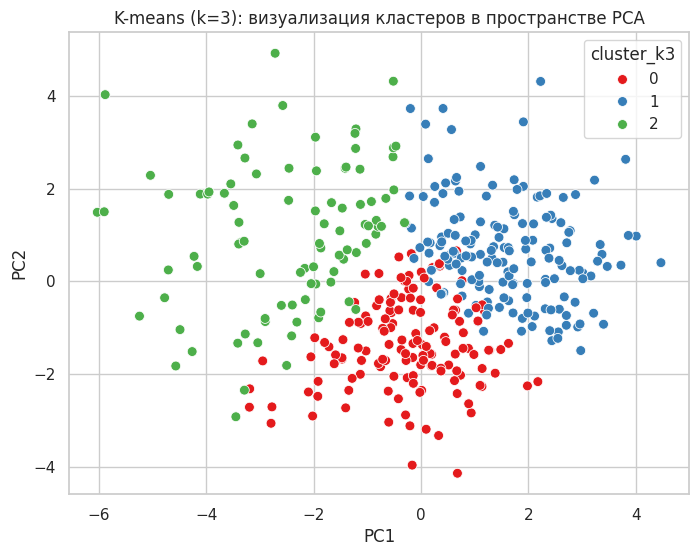

In [15]:
# Визуализация кластеров в пространстве первых двух главных компонент (PCA)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_k3, palette="Set1", s=50)
plt.title("K-means (k=3): визуализация кластеров в пространстве PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="cluster_k3")
plt.show()

Алгоритм **k-means** разбивает студентов на несколько групп, минимизируя сумму квадратов расстояний от точек до центров кластеров. Визуализация в пространстве главных компонент показывает, что кластеры частично разделимы, однако границы между ними не идеальны, что отражается в среднем значении коэффициента силуэта.

### 2.2. Подбор оптимального числа кластеров (метод локтя)

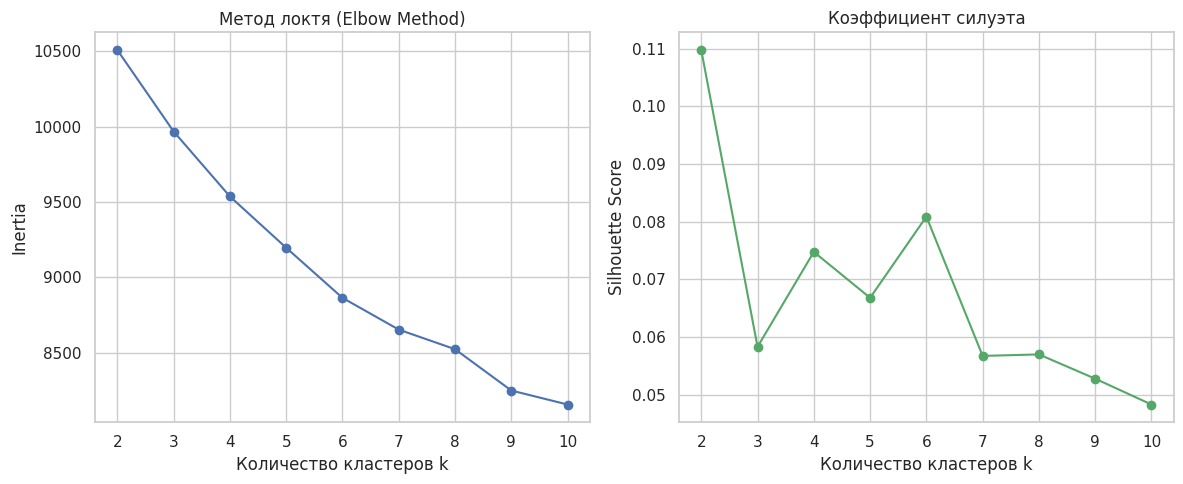

In [16]:
K = range(2, 11)
inertias = []
silhouettes = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertias, 'bo-')
plt.xlabel('Количество кластеров k')
plt.ylabel('Inertia')
plt.title('Метод локтя (Elbow Method)')

plt.subplot(1,2,2)
plt.plot(K, silhouettes, 'go-')
plt.xlabel('Количество кластеров k')
plt.ylabel('Silhouette Score')
plt.title('Коэффициент силуэта')
plt.tight_layout()
plt.show()

На графике **метода локтя** (Inertia vs k) ищем точку излома, после которой уменьшение `inertia` замедляется. Дополнительно ориентируемся на максимум коэффициента силуэта. На основе этих графиков можно выбрать разумное значение `k` (например, `k = 3` или `k = 4`).

### 2.3. K-means с выбранным оптимальным числом кластеров

In [17]:
# Предположим по графику, что оптимальным является k = 4
k_opt = 4
kmeans_opt = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
clusters_kopt = kmeans_opt.fit_predict(X_scaled)

df_not_processed['cluster_kopt'] = clusters_kopt

print(df_not_processed['cluster_kopt'].value_counts())

cluster_kopt
1    148
0    139
2     87
3     21
Name: count, dtype: int64


In [27]:
# Статистика по кластерам для k_opt
numeric_for_clustering = df_not_processed.select_dtypes(include=['int64', 'float64']).columns

cluster_stats_kopt = df_not_processed.groupby('cluster_kopt')[numeric_for_clustering].mean()
cluster_stats_kopt


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,cluster_dbscan
cluster_kopt,,,,,,,,,,,,,,,,,
0,16.690647,2.208633,2.115108,1.446043,2.172662,0.460432,3.949640,2.942446,2.877698,1.107914,1.812950,3.517986,4.755396,8.683453,8.172662,7.294964,-1.0
1,16.398649,3.202703,2.851351,1.290541,2.182432,0.040541,4.047297,3.182432,2.810811,1.114865,1.790541,3.378378,4.162162,13.763514,13.885135,14.094595,-1.0
2,16.896552,3.045977,2.816092,1.666667,1.724138,0.379310,3.770115,3.712644,3.942529,2.620690,3.770115,3.896552,9.448276,10.206897,10.080460,10.011494,-1.0
3,18.000000,1.904762,1.666667,1.666667,1.380952,1.380952,3.904762,3.571429,3.285714,1.809524,2.857143,3.619048,7.428571,8.428571,7.809524,6.809524,-1.0


In [28]:
# Метрики качества для k_opt
sil_kopt = silhouette_score(X_scaled, clusters_kopt)
ch_kopt = calinski_harabasz_score(X_scaled, clusters_kopt)
db_kopt = davies_bouldin_score(X_scaled, clusters_kopt)

print(f"Silhouette Score (k={k_opt}): {sil_kopt:.3f}")
print(f"Calinski-Harabasz Score (k={k_opt}): {ch_kopt:.1f}")
print(f"Davies-Bouldin Score (k={k_opt}): {db_kopt:.3f}")

Silhouette Score (k=4): 0.075
Calinski-Harabasz Score (k=4): 26.2
Davies-Bouldin Score (k=4): 2.748


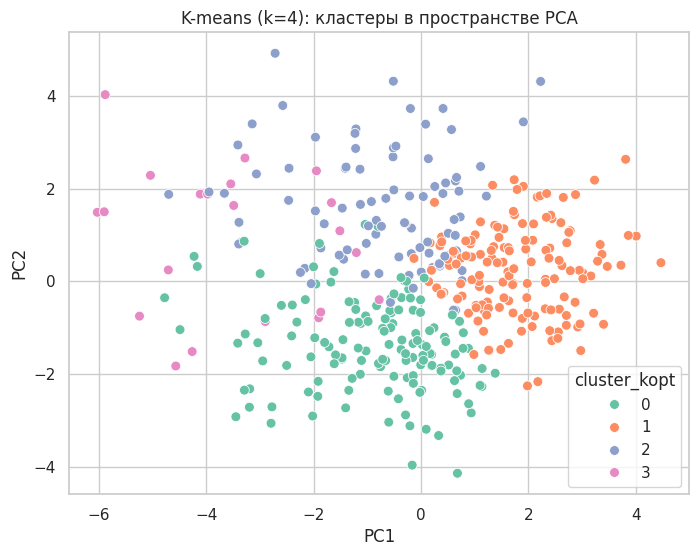

In [20]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_kopt, palette="Set2", s=50)
plt.title(f'K-means (k={k_opt}): кластеры в пространстве PCA')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="cluster_kopt")
plt.show()

С увеличением числа кластеров модель `k-means` лучше подстраивается под структуру данных, однако слишком большое количество кластеров приводит к переразбиению и ухудшению интерпретируемости. Оценка по метрикам (коэффициент силуэта, Calinski-Harabasz, Davies-Bouldin) позволяет выбрать компромисс между качеством и простотой модели.

## 3. Кластеризация DBSCAN

### 3.1. Подбор параметра eps с помощью графика расстояний

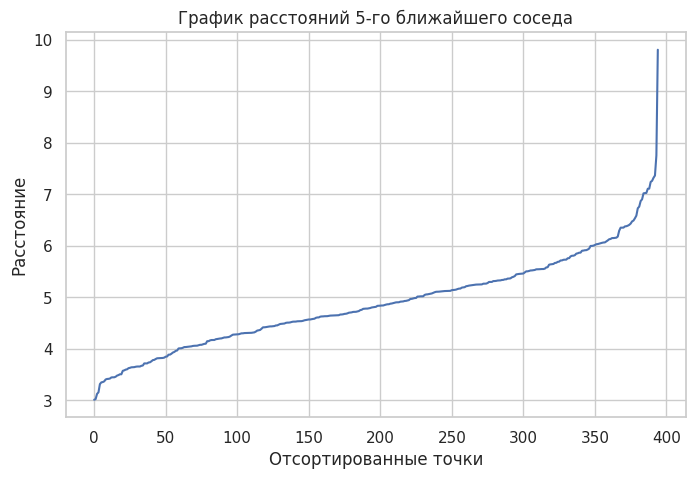

In [21]:
# Для подбора eps построим график расстояний до k-го ближайшего соседа
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# сортируем расстояния
distances = np.sort(distances[:, -1])

plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title('График расстояний 5-го ближайшего соседа')
plt.ylabel('Расстояние')
plt.xlabel('Отсортированные точки')
plt.show()

На графике можно визуально определить точку излома и выбрать значение `eps` так, чтобы отделить плотные кластеры от шума. В дальнейшем подберём параметры DBSCAN вручную, ориентируясь на этот график и результаты метрик.

### 3.2. DBSCAN с подобранными параметрами

In [22]:
# Выберем некоторое значение eps и min_samples (подбирается экспериментально)
eps_val = 2.0
min_samples_val = 5

dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
clusters_db = dbscan.fit_predict(X_scaled)

df_not_processed['cluster_dbscan'] = clusters_db

unique, counts = np.unique(clusters_db, return_counts=True)
dict(zip(unique, counts))

{np.int64(-1): np.int64(395)}

In [23]:
# Метрики для DBSCAN (игнорируем шум с меткой -1)
mask = clusters_db != -1

if len(np.unique(clusters_db[mask])) > 1:
    sil_db = silhouette_score(X_scaled[mask], clusters_db[mask])
    ch_db = calinski_harabasz_score(X_scaled[mask], clusters_db[mask])
    db_db = davies_bouldin_score(X_scaled[mask], clusters_db[mask])

    print(f"Silhouette Score (DBSCAN): {sil_db:.3f}")
    print(f"Calinski-Harabasz Score (DBSCAN): {ch_db:.1f}")
    print(f"Davies-Bouldin Score (DBSCAN): {db_db:.3f}")
else:
    print('DBSCAN выделил менее двух кластеров (кроме шума) — метрики силуэта и т.п. не рассчитываются.')

DBSCAN выделил менее двух кластеров (кроме шума) — метрики силуэта и т.п. не рассчитываются.


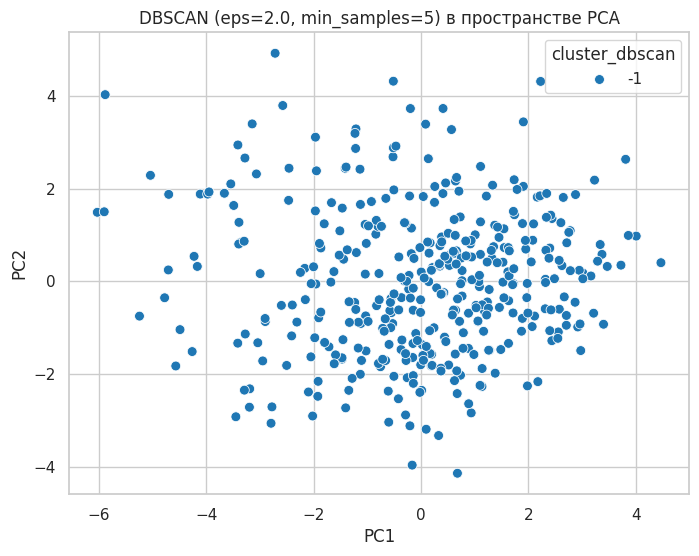

In [24]:
plt.figure(figsize=(8,6))
palette = sns.color_palette("tab10", n_colors=len(np.unique(clusters_db)))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_db, palette="tab10", s=50)
plt.title(f'DBSCAN (eps={eps_val}, min_samples={min_samples_val}) в пространстве PCA')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="cluster_dbscan")
plt.show()

DBSCAN выделяет кластеры как области повышенной плотности и позволяет отмечать точки-аномалии (шум) меткой `-1`. Визуализация показывает, какие группы студентов образуют плотные кластеры, а какие наблюдения выбиваются из общей картины.

## 4. Выводы по методам кластеризации

K-means лучше всего работает, когда кластеры имеют круглую форму и примерно одинаковый размер. В случае с нашим датасетом про успеваемость студентов этот алгоритм помогает разделить учащихся на несколько групп по их оценкам, количеству пропусков, времени, которое они тратят на учёбу, и другим числовым показателям. По метрикам качества (silhouette score и Calinski–Harabasz) видно, что k-means показывает довольно стабильные результаты, особенно если выбирать небольшое число кластеров (примерно 3–4).

DBSCAN удобен тем, что для него не нужно заранее задавать количество кластеров, и он умеет выделять шум — то есть аномальные точки. Это полезно, когда нужно найти студентов с необычными характеристиками, например, с очень большим числом пропусков или слишком низкими/высокими оценками. Но у DBSCAN есть минусы: если признаков много и плотные области выражены плохо, он может собрать почти всех в один большой кластер, либо создать много маленьких кластеров и шум. К тому же результат сильно зависит от параметров eps и min_samples.

В итоге для нашего датасета по успеваемости k-means кажется более удобным и понятным вариантом. Он формирует логичные группы студентов по уровню их успеваемости и другим числовым данным. DBSCAN, конечно, тоже можно использовать, но больше как дополнительный инструмент, чтобы находить редкие и необычные случаи, а не как основной метод кластеризации.